In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date, timedelta
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Input, Flatten, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import re

In [3]:
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [831]:
triker1 = 'AAPL'
triker = triker1.lower()


trend = 'downtrend'
# trend = 'uptrend'
tmax_trials = 10
tepochs = 5
fepochs = 1

In [832]:
# PATH = 'C:/Users/Simon/stock/stock_data/'
# path = 'C:/Users/Simon/stock/'
PATH = '/content/drive/MyDrive/stock_data/'
path = '/content/drive/MyDrive/stock_GCN_info/'

In [833]:
ns = ['adbe', 'amt', 'pld', 'vici', 'schw', 'jpm', 'atvi', 'cvs', 'bio', 'jnj']

In [834]:
def se(triker):
    if triker in ns:
      stock = pd.read_csv(PATH + triker + '_Simon/stocks_ts_'+triker1+'_2021-1-4_2022-9-20.csv')
      stock = stock[stock['date']>= '2021-01-01']
      stock = stock.iloc[:,0:25].drop(columns=['symbol', 'NextDayClose', 'NextDayTrend',	'PrevDayTrend'])
    else:
      stock = pd.read_csv(PATH + triker + '_Simon/stocks_ts_'+triker1+'_2021-1-4_2022-9-20.csv')
      stock = stock[stock['date']>= '2021-01-01']
      stock = stock.iloc[:,0:25].drop(columns=['symbol', 'NextDayClose', 'NextDayTrend',	'PrevDayTrend', 'splits'])
    return stock

# Load package 1

In [835]:
import numpy as np
from scipy import sparse as sp

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.python.ops.linalg.sparse import sparse as tfsp
from tensorflow.keras import backend as K

SINGLE  = 1   # Single         (rank(a)=2, rank(b)=2)
MIXED   = 2   # Mixed          (rank(a)=2, rank(b)=3)
iMIXED  = 3   # Inverted mixed (rank(a)=3, rank(b)=2)
BATCH   = 4   # Batch          (rank(a)=3, rank(b)=3)
UNKNOWN = -1  # Unknown


def transpose(a, perm=None, name=None):
    """
    Transposes a according to perm, dealing automatically with sparsity.
    :param a: Tensor or SparseTensor with rank k.
    :param perm: permutation indices of size k.
    :param name: name for the operation.
    :return: Tensor or SparseTensor with rank k.
    """
    if K.is_sparse(a):
        transpose_op = tf.sparse.transpose
    else:
        transpose_op = tf.transpose

    if perm is None:
        perm = (1, 0)  # Make explicit so that shape will always be preserved
    return transpose_op(a, perm=perm, name=name)


def reshape(a, shape=None, name=None):
    """
    Reshapes a according to shape, dealing automatically with sparsity.
    :param a: Tensor or SparseTensor.
    :param shape: new shape.
    :param name: name for the operation.
    :return: Tensor or SparseTensor.
    """
    if K.is_sparse(a):
        reshape_op = tf.sparse.reshape
    else:
        reshape_op = tf.reshape

    return reshape_op(a, shape=shape, name=name)


def autodetect_mode(a, b):
    """
    Return a code identifying the mode of operation (single, mixed, inverted mixed and
    batch), given a and b. See `ops.modes` for meaning of codes.
    :param a: Tensor or SparseTensor.
    :param b: Tensor or SparseTensor.
    :return: mode of operation as an integer code.
    """
    a_dim = K.ndim(a)
    b_dim = K.ndim(b)
    if b_dim == 2:
        if a_dim == 2:
            return SINGLE
        elif a_dim == 3:
            return iMIXED
    elif b_dim == 3:
        if a_dim == 2:
            return MIXED
        elif a_dim == 3:
            return BATCH
    return UNKNOWN


def filter_dot(fltr, features):
    """
    Wrapper for matmul_A_B, specifically used to compute the matrix multiplication
    between a graph filter and node features.
    :param fltr:
    :param features: the node features (N x F in single mode, batch x N x F in
    mixed and batch mode).
    :return: the filtered features.
    """
    mode = autodetect_mode(fltr, features)
    if mode == SINGLE or mode == BATCH:
        return dot(fltr, features)
    else:
        # Mixed mode
        return mixed_mode_dot(fltr, features)


def dot(a, b, transpose_a=False, transpose_b=False):
    """
    Dot product between a and b along innermost dimensions, for a and b with
    same rank. Supports both dense and sparse multiplication (including
    sparse-sparse).
    :param a: Tensor or SparseTensor with rank 2 or 3.
    :param b: Tensor or SparseTensor with same rank as a.
    :param transpose_a: bool, transpose innermost two dimensions of a.
    :param transpose_b: bool, transpose innermost two dimensions of b.
    :return: Tensor or SparseTensor with rank 2 or 3.
    """
    a_is_sparse_tensor = isinstance(a, tf.SparseTensor)
    b_is_sparse_tensor = isinstance(b, tf.SparseTensor)
    if a_is_sparse_tensor:
        a = tfsp.CSRSparseMatrix(a)
    if b_is_sparse_tensor:
        b = tfsp.CSRSparseMatrix(b)
    out = tfsp.matmul(a, b, transpose_a=transpose_a, transpose_b=transpose_b)
    if hasattr(out, 'to_sparse_tensor'):
        return out.to_sparse_tensor()

    return out


def mixed_mode_dot(a, b):
    """
    Computes the equivalent of `tf.einsum('ij,bjk->bik', a, b)`, but
    works for both dense and sparse input filters.
    :param a: rank 2 Tensor or SparseTensor.
    :param b: rank 3 Tensor or SparseTensor.
    :return: rank 3 Tensor or SparseTensor.
    """
    s_0_, s_1_, s_2_ = K.int_shape(b)
    B_T = transpose(b, (1, 2, 0))
    B_T = reshape(B_T, (s_1_, -1))
    output = dot(a, B_T)
    output = reshape(output, (s_1_, s_2_, -1))
    output = transpose(output, (2, 0, 1))

    return output


def degree_power(A, k):
    r"""
    Computes \(\D^{k}\) from the given adjacency matrix. Useful for computing
    normalised Laplacian.
    :param A: rank 2 array or sparse matrix.
    :param k: exponent to which elevate the degree matrix.
    :return: if A is a dense array, a dense array; if A is sparse, a sparse
    matrix in DIA format.
    """
    degrees = np.power(np.array(A.sum(1)), k).flatten()
    degrees[np.isinf(degrees)] = 0.
    if sp.issparse(A):
        D = sp.diags(degrees)
    else:
        D = np.diag(degrees)
    return D


def normalized_adjacency(A, symmetric=True):
    r"""
    Normalizes the given adjacency matrix using the degree matrix as either
    \(\D^{-1}\A\) or \(\D^{-1/2}\A\D^{-1/2}\) (symmetric normalization).
    :param A: rank 2 array or sparse matrix;
    :param symmetric: boolean, compute symmetric normalization;
    :return: the normalized adjacency matrix.
    """
    if symmetric:
        normalized_D = degree_power(A, -0.5)
        output = normalized_D.dot(A).dot(normalized_D)
    else:
        normalized_D = degree_power(A, -1.)
        output = normalized_D.dot(A)
    return output


def localpooling_filter(A, symmetric=True):
    r"""
    Computes the graph filter described in
    [Kipf & Welling (2017)](https://arxiv.org/abs/1609.02907).
    :param A: array or sparse matrix with rank 2 or 3;
    :param symmetric: boolean, whether to normalize the matrix as
    \(\D^{-\frac{1}{2}}\A\D^{-\frac{1}{2}}\) or as \(\D^{-1}\A\);
    :return: array or sparse matrix with rank 2 or 3, same as A;
    """
    fltr = A.copy()
    if sp.issparse(A):
        I = sp.eye(A.shape[-1], dtype=A.dtype)
    else:
        I = np.eye(A.shape[-1], dtype=A.dtype)
    if A.ndim == 3:
        for i in range(A.shape[0]):
            A_tilde = A[i] + I
            fltr[i] = normalized_adjacency(A_tilde, symmetric=symmetric)
    else:
        A_tilde = A + I
        fltr = normalized_adjacency(A_tilde, symmetric=symmetric)

    if sp.issparse(fltr):
        fltr.sort_indices()
    return fltr

In [836]:
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer



class GraphConv(Layer):
    r"""
    A graph convolutional layer (GCN) as presented by
    [Kipf & Welling (2016)](https://arxiv.org/abs/1609.02907).
    **Mode**: single, mixed, batch.
    This layer computes:
    $$
        \Z = \hat \D^{-1/2} \hat \A \hat \D^{-1/2} \X \W + \b
    $$
    where \( \hat \A = \A + \I \) is the adjacency matrix with added self-loops
    and \(\hat\D\) is its degree matrix.
    **Input**
    - Node features of shape `([batch], N, F)`;
    - Modified Laplacian of shape `([batch], N, N)`; can be computed with
    `spektral.utils.convolution.localpooling_filter`.
    **Output**
    - Node features with the same shape as the input, but with the last
    dimension changed to `channels`.
    **Arguments**
    - `channels`: number of output channels;
    - `activation`: activation function to use;
    - `use_bias`: whether to add a bias to the linear transformation;
    - `kernel_initializer`: initializer for the kernel matrix;
    - `bias_initializer`: initializer for the bias vector;
    - `kernel_regularizer`: regularization applied to the kernel matrix;
    - `bias_regularizer`: regularization applied to the bias vector;
    - `activity_regularizer`: regularization applied to the output;
    - `kernel_constraint`: constraint applied to the kernel matrix;
    - `bias_constraint`: constraint applied to the bias vector.
    """

    def __init__(self,
                 channels,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):

        super().__init__(activity_regularizer=activity_regularizer, **kwargs)
        self.channels = channels
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.supports_masking = False

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[0][-1]
        self.kernel = self.add_weight(shape=(input_dim, self.channels),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.channels,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs):
        features = inputs[0]
        fltr = inputs[1]

        # Convolution
        output = dot(features, self.kernel)
        output = filter_dot(fltr, output)

        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        features_shape = input_shape[0]
        output_shape = features_shape[:-1] + (self.channels,)
        return output_shape

    def get_config(self):
        config = {
            'channels': self.channels,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @staticmethod
    def preprocess(A):
        return localpooling_filter(A)

#Load data

In [837]:
tt = ['ADBE', 'AMT', 'PLD', 'VICI', 'SCHW', 'JPM', 'ATVI', 'CVS', 'BIO', 'JNJ', 'NVDA', 'NDAQ', 'IBM', 'SBUX', 'NFLX', 'EBAY', 'AMZN', 'GOOG', 'AAPL', 'MSFT', 'TSLA']
tt

['ADBE',
 'AMT',
 'PLD',
 'VICI',
 'SCHW',
 'JPM',
 'ATVI',
 'CVS',
 'BIO',
 'JNJ',
 'NVDA',
 'NDAQ',
 'IBM',
 'SBUX',
 'NFLX',
 'EBAY',
 'AMZN',
 'GOOG',
 'AAPL',
 'MSFT',
 'TSLA']

In [838]:
appended_data = []
for ele in tt:
    triker_t = str(ele)
    # print(triker)
    triker2 = ele.lower()
    # print(triker2)
    stock = pd.read_csv(PATH + triker2 + '_Simon/stocks_ts_' + triker_t + '_2021-1-4_2022-9-20.csv')
    stock = stock[stock['date']>= '2021-01-04']
    stock = stock[stock['date']<= '2022-09-20']
    stock = stock[['date',	'symbol',	'close']]
    # store DataFrame in list
    appended_data.append(stock)
# see pd.concat documentation for more info
appended_data = pd.concat(appended_data)
# write DataFrame to an excel sheet
appended_data

,date,symbol,close
2647,2021-01-04,ADBE,485.339996
2648,2021-01-05,ADBE,485.690002
2649,2021-01-06,ADBE,466.309998
2650,2021-01-07,ADBE,477.739990
2651,2021-01-08,ADBE,485.100006
...,...,...,...
3074,2022-09-14,tsla,302.609985
3075,2022-09-15,tsla,303.750000
3076,2022-09-16,tsla,303.350006
3077,2022-09-19,tsla,309.070007


In [839]:
Multi_data1 = appended_data

In [840]:
Multi_data1.shape

(9072, 3)

# Data visualization

In [841]:
import datetime

In [842]:
### SWITCH DATA FROM VERTICAL TO HORIZONTAL FORMAT ###

unstaked_df = Multi_data1.copy()
# unstaked_df = unstaked_df.iloc[:,0:20]
unstaked_df.set_index(['date','symbol'], inplace=True)
unstaked_df = unstaked_df.astype(float).unstack().T
print(unstaked_df.index[0][0])
print(type(unstaked_df.index[0][0]))

name = []
symbol = []
for i in unstaked_df.index:
  name.append(i[0])
  symbol.append(i[1])

unstaked_df['id2'] = name
unstaked_df['id1'] = symbol
unstaked_df['id'] = unstaked_df['id1'].astype(str)+'_'+unstaked_df['id2'].astype(str)
unstaked_df.set_index(['id'], inplace=True)
unstaked_df.drop(['id2','id1'], axis=1, inplace=True)
unstaked_df.columns = pd.to_datetime(unstaked_df.columns)
print(type(unstaked_df.columns))

print(unstaked_df.shape)
unstaked_df.head()

close
<class 'str'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
(21, 432)


date,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,...,2022-09-07,2022-09-08,2022-09-09,2022-09-12,2022-09-13,2022-09-14,2022-09-15,2022-09-16,2022-09-19,2022-09-20
id,,,,,,,,,,,,,,,,,,,,,
ADBE_close,485.339996,485.690002,466.309998,477.739990,485.100006,474.239990,471.649994,472.049988,463.269989,458.079987,...,379.720001,383.630005,394.779999,396.359985,368.390015,371.519989,309.130005,299.500000,296.059998,291.059998
AMT_close,219.600006,220.710007,214.889999,217.500000,222.199997,214.919998,214.910004,216.460007,214.990005,219.889999,...,259.500000,261.670013,261.589996,265.089996,254.630005,251.820007,245.059998,245.889999,247.500000,237.899994
AMZN_close,159.331497,160.925507,156.919006,158.108002,159.134995,155.710495,156.041504,158.294495,156.373505,155.212494,...,129.479996,129.820007,133.270004,136.449997,126.820000,128.550003,126.279999,123.529999,124.660004,122.190002
ATVI_close,89.900002,90.690002,88.000000,89.669998,91.300003,90.910004,89.250000,89.769997,89.989998,90.690002,...,77.720001,77.389999,78.510002,78.129997,76.760002,76.599998,76.830002,76.019997,75.940002,75.040001
BIO_close,575.260010,584.130005,612.200012,629.119995,621.369995,615.789978,610.039978,604.320007,593.140015,601.150024,...,491.380005,500.329987,509.380005,512.789978,479.399994,477.480011,472.750000,448.540009,445.500000,437.390015


In [843]:
# idx = pd.date_range(start='2021-01-05', end='2022-09-20')
# unstaked_df = unstaked_df.T.reindex(idx).T

# unstaked_df.fillna(method='ffill', axis=1, inplace=True)


unstaked_df = unstaked_df.sort_index(ascending=True)
unstaked_df

date,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,...,2022-09-07,2022-09-08,2022-09-09,2022-09-12,2022-09-13,2022-09-14,2022-09-15,2022-09-16,2022-09-19,2022-09-20
id,,,,,,,,,,,,,,,,,,,,,
ADBE_close,485.339996,485.690002,466.309998,477.739990,485.100006,474.239990,471.649994,472.049988,463.269989,458.079987,...,379.720001,383.630005,394.779999,396.359985,368.390015,371.519989,309.130005,299.500000,296.059998,291.059998
AMT_close,219.600006,220.710007,214.889999,217.500000,222.199997,214.919998,214.910004,216.460007,214.990005,219.889999,...,259.500000,261.670013,261.589996,265.089996,254.630005,251.820007,245.059998,245.889999,247.500000,237.899994
AMZN_close,159.331497,160.925507,156.919006,158.108002,159.134995,155.710495,156.041504,158.294495,156.373505,155.212494,...,129.479996,129.820007,133.270004,136.449997,126.820000,128.550003,126.279999,123.529999,124.660004,122.190002
ATVI_close,89.900002,90.690002,88.000000,89.669998,91.300003,90.910004,89.250000,89.769997,89.989998,90.690002,...,77.720001,77.389999,78.510002,78.129997,76.760002,76.599998,76.830002,76.019997,75.940002,75.040001
BIO_close,575.260010,584.130005,612.200012,629.119995,621.369995,615.789978,610.039978,604.320007,593.140015,601.150024,...,491.380005,500.329987,509.380005,512.789978,479.399994,477.480011,472.750000,448.540009,445.500000,437.390015
CVS_close,69.989998,70.459999,72.559998,73.989998,74.860001,76.070000,76.260002,74.919998,75.050003,76.260002,...,100.680000,102.260002,102.150002,103.040001,100.449997,101.050003,102.309998,102.059998,102.110001,101.339996
EBAY_close,51.500000,52.029999,53.220001,53.060001,54.480000,53.930000,56.040001,55.709999,55.270000,55.419998,...,44.660000,44.250000,45.099998,45.520000,42.790001,42.570000,42.660000,42.000000,41.349998,39.900002
GOOG_close,86.412003,87.045998,86.764503,89.362503,90.360497,88.335999,87.327499,87.720001,87.009003,86.809502,...,110.480003,109.419998,111.779999,111.870003,105.309998,105.870003,103.900002,103.629997,103.849998,101.830002
IBM_close,118.489487,120.592735,123.604210,123.317398,122.877632,122.925430,123.527725,121.338432,123.298279,122.743790,...,127.709999,128.470001,129.190002,130.660004,127.250000,127.690002,125.489998,127.269997,127.730003,126.300003


# function for GCN model

In [844]:
### UTILITY FUNCTIONS FOR FEATURE ENGINEERING ###

sequence_length = 14
ns = 21
sf = int(sequence_length/2)

# sf = round(sequence_length/2)

# def get_timespan(df, today, days):
#     df = df[pd.date_range(today - timedelta(days=days),
#             periods=days, freq='D')] # day - n_days <= dates < day
#     return df


def get_timespan(df, today, days):
    df = unstaked_df.iloc[:, unstaked_df.columns.get_loc(today)+1-days:unstaked_df.columns.get_loc(today)+1] # day - n_days <= dates < day
    return df


# def create_features(df, today, seq_len):

#     all_sequence = get_timespan(df, today, seq_len).values

#     group_store = all_sequence.reshape((-1, ns, seq_len))

#     store_corr = np.stack([np.corrcoef(i) for i in group_store], axis=0)

#     store_features = np.stack([
#               group_store.mean(axis=2),
#               group_store[:,:,sf:].mean(axis=2),
#               group_store.std(axis=2),
#               group_store[:,:,sf:].std(axis=2),
#               skew(group_store, axis=2),
#               kurtosis(group_store, axis=2),
#               np.apply_along_axis(lambda x: np.polyfit(np.arange(0, time_steps), x, 1)[0], 2, group_store)
#             ], axis=1)

#     group_store = np.transpose(group_store, (0,2,1))

#     store_features = np.transpose(store_features, (0,2,1))

#     return group_store, store_corr, store_features

In [845]:
#test for narmalization for close GCN price
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import MinMaxScaler


# scaler = MinMaxScaler()
# scaler = RobustScaler()
scaler = StandardScaler()

unstaked_df.iloc[:,0:432] = scaler.fit_transform(unstaked_df.iloc[:,0:432])
# unstaked_df = unstaked_df.sort_values(by=["date"])
unstaked_df

date,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,...,2022-09-07,2022-09-08,2022-09-09,2022-09-12,2022-09-13,2022-09-14,2022-09-15,2022-09-16,2022-09-19,2022-09-20
id,,,,,,,,,,,,,,,,,,,,,
ADBE_close,1.995317,1.980819,1.866121,1.861256,1.893533,1.886863,1.885166,1.874382,1.865617,1.831624,...,1.910172,1.902997,1.926610,1.910963,1.877140,1.885940,1.429283,1.402038,1.364676,1.355342
AMT_close,0.279356,0.278007,0.246533,0.229231,0.246711,0.225476,0.228184,0.232786,0.239733,0.274066,...,0.844746,0.838455,0.792374,0.801702,0.845863,0.806222,0.821290,0.874876,0.886396,0.824181
AMZN_close,-0.109816,-0.106180,-0.126903,-0.143230,-0.148332,-0.153862,-0.151749,-0.140798,-0.144123,-0.148870,...,-0.307530,-0.312414,-0.300389,-0.285336,-0.312781,-0.305699,-0.305874,-0.328324,-0.323487,-0.331964
ATVI_close,-0.558156,-0.557527,-0.570863,-0.572420,-0.573254,-0.569019,-0.582817,-0.580916,-0.578841,-0.570792,...,-0.766243,-0.770055,-0.766721,-0.778154,-0.766593,-0.774299,-0.775130,-0.795503,-0.803343,-0.803074
BIO_close,2.575957,2.613413,2.805910,2.810594,2.747136,2.793731,2.778325,2.723923,2.716083,2.767180,...,2.899736,2.921627,2.902534,2.894824,2.883486,2.841721,2.981956,2.867589,2.836550,2.817433
CVS_close,-0.686720,-0.687528,-0.670324,-0.670753,-0.676235,-0.664095,-0.666653,-0.676294,-0.676677,-0.665152,...,-0.562764,-0.552975,-0.565404,-0.567658,-0.551835,-0.553755,-0.533338,-0.539444,-0.545588,-0.540292
EBAY_close,-0.806116,-0.805963,-0.794907,-0.802010,-0.803897,-0.805939,-0.797152,-0.799675,-0.806209,-0.801427,...,-1.059230,-1.059322,-1.051238,-1.053716,-1.074544,-1.081256,-1.099387,-1.130031,-1.144029,-1.154184
GOOG_close,-0.580679,-0.580944,-0.578822,-0.574349,-0.579139,-0.585510,-0.595224,-0.594082,-0.598363,-0.596167,...,-0.475914,-0.490478,-0.483396,-0.493043,-0.507777,-0.510277,-0.518249,-0.524006,-0.528451,-0.535396
IBM_close,-0.373545,-0.365366,-0.341509,-0.361410,-0.375450,-0.363906,-0.361591,-0.378159,-0.360719,-0.361187,...,-0.323217,-0.324198,-0.335134,-0.334263,-0.308883,-0.313456,-0.313371,-0.291547,-0.293250,-0.290898


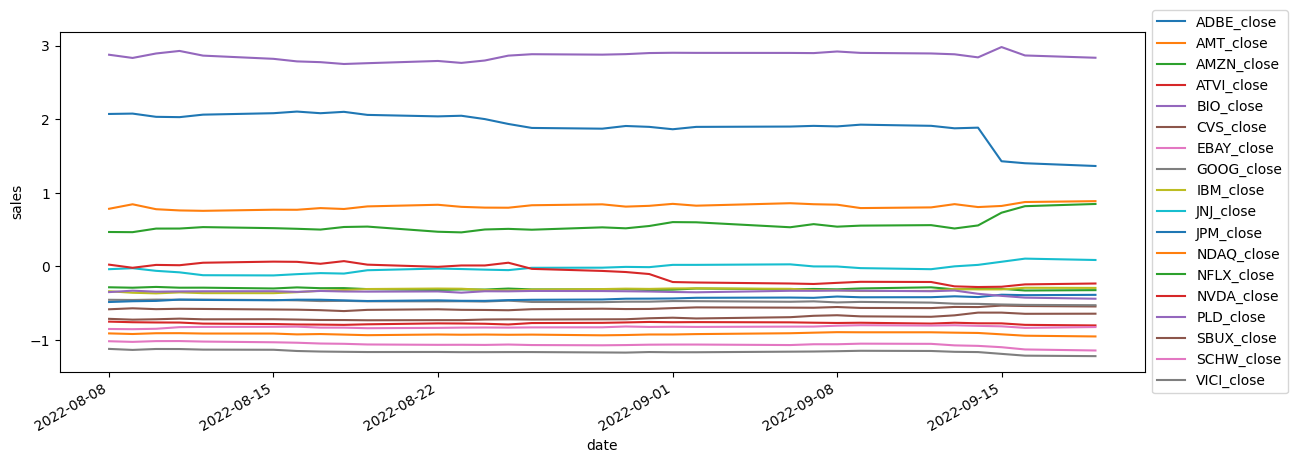

In [846]:
### PLOT A SEQUENCE OF SALES FOR ITEM 10 IN ALL STORES ###

# sequence = get_timespan(unstaked_df, date(2022,9,1), 30)
# sequence.head(18).T.plot(figsize=(14,5))
# plt.ylabel('sales')
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

sequence = get_timespan(unstaked_df, '2022-09-19', 30)
sequence.head(18).T.plot(figsize=(14,5))
plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

#create model

In [847]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###

# pred_valid_all = np.zeros(y_valid.shape)
# pred_test_all = np.zeros(y_test.shape)

# for stock in range(21):

#     print('-------', 'stock', stock, '-------')

#     es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

#     model = get_model()
#     model.fit([X_train_seq, X_train_lap, X_train_feat],
#               y_train[:,stock],
#               epochs=100,
#               batch_size=256,
#               validation_data=([X_valid_seq, X_valid_lap, X_valid_feat],
#                                y_valid[:,stock]),
#               callbacks=[es],
#               verbose=2)

#     pred_valid_all[:,stock] = model.predict([X_valid_seq, X_valid_lap, X_valid_feat]).ravel()
#     pred_test_all[:,stock] = model.predict([X_test_seq, X_test_lap, X_test_feat]).ravel()


# pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
# reverse_valid = scaler_seq.inverse_transform(y_valid)
# pred_test_all = scaler_seq.inverse_transform(pred_test_all)
# reverse_test = scaler_seq.inverse_transform(y_test)

# Load Multimodal data

In [848]:
tt[0]

'ADBE'

In [849]:
appended_data = []
for ele in tt:
    triker_t = str(ele)
    # print(triker)
    triker2 = ele.lower()
    # print(triker1)
    stock = pd.read_csv(PATH + triker2 + '_Simon/stocks_ts_' + triker_t + '_2021-1-4_2022-9-20.csv')
    stock = stock[stock['date']>= '2021-01-01']
    stock = stock[stock['date']<= '2022-09-20']
    # store DataFrame in list
    appended_data.append(stock)
# see pd.concat documentation for more info
appended_data = pd.concat(appended_data)
appended_data = appended_data.drop(['NextDayTrend',	'PrevDayTrend',	'dividends',	'splits'], axis = 1)
# write DataFrame to an excel sheet
appended_data

,date,symbol,low,close,high,volume,open,adjclose,rsi,12-Day EMA,26-Day EMA,MACD,SAR,Upper Band,Middle Band,Lower Band,Slow k,Slow d,NextDayClose,PrevDayClose
2647,2021-01-04,ADBE,476.279999,485.339996,500.790009,3612900,500.299988,485.339996,47.221636,4.859534,5.650625,-0.791091,506.920013,508.646254,496.794000,484.941747,29.627983,35.603101,485.690002,500.119995
2648,2021-01-05,ADBE,479.200012,485.690002,486.079987,2010100,485.880005,485.690002,47.461750,3.777457,5.275992,-1.498534,506.307213,508.538656,494.141998,479.745341,36.573119,34.852352,466.309998,485.339996
2649,2021-01-06,ADBE,466.000000,466.309998,475.869995,4156600,474.100006,466.309998,37.333714,1.340646,4.488923,-3.148277,505.706669,510.879839,486.982001,463.084163,21.207197,29.136100,477.739990,485.690002
2650,2021-01-07,ADBE,468.250000,477.739990,479.640015,2901200,471.000000,477.739990,44.813529,0.327979,3.656734,-3.328755,504.118402,505.167297,483.039996,460.912695,22.307785,26.696034,485.100006,466.309998
2651,2021-01-08,ADBE,477.209991,485.100006,485.540009,2266100,480.000000,485.100006,49.032152,0.117965,2.948980,-2.831015,502.593666,494.987094,480.035999,465.084903,29.818016,24.444333,474.239990,477.739990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3074,2022-09-14,tsla,291.640015,302.609985,306.000000,72628700,292.239990,302.609985,58.547232,3.502746,2.522179,0.980567,269.485106,309.466121,297.620001,285.773882,81.390758,88.507238,303.750000,292.130005
3075,2022-09-15,tsla,300.720001,303.750000,309.119995,64795500,301.829987,303.750000,59.083981,4.215617,2.860867,1.354751,271.676000,309.511715,300.517999,291.524284,72.726057,79.882618,303.350006,302.609985
3076,2022-09-16,tsla,295.600006,303.350006,303.709991,86949500,299.609985,303.350006,58.796310,4.694186,3.227531,1.466655,274.671519,310.449082,301.252002,292.054921,75.857425,76.658080,309.070007,303.750000
3077,2022-09-19,tsla,297.799988,309.070007,309.839996,60231200,300.089996,309.070007,61.670319,5.471934,3.676411,1.795522,277.427397,313.227119,302.182001,291.136883,78.843564,75.809015,308.730011,303.350006


In [850]:
stock = appended_data

In [851]:
stock['Diff'] = stock['close'] - stock['PrevDayClose']
stock['Diff'] = stock['Diff'].apply(lambda x: 1 if x > 0 else 0)
stock.head(3)

,date,symbol,low,close,high,volume,open,adjclose,rsi,12-Day EMA,...,MACD,SAR,Upper Band,Middle Band,Lower Band,Slow k,Slow d,NextDayClose,PrevDayClose,Diff
2647,2021-01-04,ADBE,476.279999,485.339996,500.790009,3612900,500.299988,485.339996,47.221636,4.859534,...,-0.791091,506.920013,508.646254,496.794000,484.941747,29.627983,35.603101,485.690002,500.119995,0
2648,2021-01-05,ADBE,479.200012,485.690002,486.079987,2010100,485.880005,485.690002,47.461750,3.777457,...,-1.498534,506.307213,508.538656,494.141998,479.745341,36.573119,34.852352,466.309998,485.339996,1
2649,2021-01-06,ADBE,466.000000,466.309998,475.869995,4156600,474.100006,466.309998,37.333714,1.340646,...,-3.148277,505.706669,510.879839,486.982001,463.084163,21.207197,29.136100,477.739990,485.690002,0


In [852]:
news = pd.read_csv(PATH +triker+'_Simon/Single_newsheadline_day_'+triker+'.csv')
news = news[['date', 'Titles']]
news

,date,Titles
0,2021-01-05,Two former Apple insiders are building a laser...
1,2021-01-06,NaN
2,2021-01-07,Dow Jones Futures Rise: Congress Certifies Bid...
3,2021-01-08,"The Best Mutual Funds Bet These Tech Stocks, I..."
4,2021-01-11,Short Selling Legend Jim Chanos’ Top 10 Stock ...
...,...,...
403,2022-09-14,Apple plans to use latest chip tech by Taiwan'...
404,2022-09-15,Alphabet (GOOGL) Enhances Google Photos With R...
405,2022-09-16,Apple Counts on Upscale Shoppers to Turn Lates...
406,2022-09-19,"With EPS Growth And More, Apple (NASDAQ:AAPL) ..."


In [853]:
Single_newsheadline_day_stock = news.merge(stock, on = 'date')
Single_newsheadline_day_stock

,date,Titles,symbol,low,close,high,volume,open,adjclose,rsi,...,MACD,SAR,Upper Band,Middle Band,Lower Band,Slow k,Slow d,NextDayClose,PrevDayClose,Diff
0,2021-01-05,Two former Apple insiders are building a laser...,ADBE,479.200012,485.690002,486.079987,2010100,485.880005,485.690002,47.461750,...,-1.498534,506.307213,508.538656,494.141998,479.745341,36.573119,34.852352,466.309998,485.339996,1
1,2021-01-05,Two former Apple insiders are building a laser...,AMT,219.089996,220.710007,222.600006,2481600,220.119995,210.900467,45.156957,...,0.744821,216.753619,224.541698,221.118002,217.694307,48.330660,59.406658,214.889999,219.600006,1
2,2021-01-05,Two former Apple insiders are building a laser...,PLD,95.910004,96.190002,97.239998,3844400,96.150002,91.938095,42.541666,...,0.006463,100.664602,100.532912,97.686002,94.839091,34.757022,56.791718,93.910004,96.040001,1
3,2021-01-05,Two former Apple insiders are building a laser...,VICI,24.510000,24.969999,25.190001,4441500,24.620001,22.681921,43.985504,...,-0.154060,26.321652,25.941793,25.210000,24.478207,20.252102,24.154021,25.030001,24.650000,1
4,2021-01-05,Two former Apple insiders are building a laser...,SCHW,51.939999,52.770000,52.950001,7995700,51.959999,51.482464,66.192968,...,-0.165039,51.930000,53.136408,52.704000,52.271593,62.992749,61.729804,57.410000,52.759998,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8563,2022-09-20,Amazon's growth under Andy Jassy allows for 'm...,AMZN,121.139999,122.190002,124.400002,47698400,123.349998,122.190002,39.536130,...,-1.031627,135.049501,129.460570,125.042001,120.623433,23.446899,19.966614,118.540001,124.660004,0
8564,2022-09-20,Amazon's growth under Andy Jassy allows for 'm...,GOOG,101.120003,101.830002,103.169998,24001700,102.879997,101.830002,31.970419,...,-0.737330,110.250557,106.378175,103.816000,101.253825,18.984583,16.210504,100.010002,103.849998,0
8565,2022-09-20,Amazon's growth under Andy Jassy allows for 'm...,aapl,153.080002,156.899994,158.080002,107689800,153.399994,156.899994,47.905105,...,-0.544921,162.776815,158.323894,153.951996,149.580098,50.905422,30.036943,153.720001,154.479996,1
8566,2022-09-20,Amazon's growth under Andy Jassy allows for 'm...,msft,239.639999,242.449997,243.509995,26660300,242.070007,242.449997,29.805123,...,-1.925671,261.250301,252.516811,245.862003,239.207195,16.195833,12.610707,238.949997,244.520004,0


In [854]:
Multi_data = Single_newsheadline_day_stock

In [855]:
# drop NA
Multi_data = Multi_data.dropna()
Multi_data = Multi_data.drop(columns=['PrevDayClose'])
Multi_data

,date,Titles,symbol,low,close,high,volume,open,adjclose,rsi,...,26-Day EMA,MACD,SAR,Upper Band,Middle Band,Lower Band,Slow k,Slow d,NextDayClose,Diff
0,2021-01-05,Two former Apple insiders are building a laser...,ADBE,479.200012,485.690002,486.079987,2010100,485.880005,485.690002,47.461750,...,5.275992,-1.498534,506.307213,508.538656,494.141998,479.745341,36.573119,34.852352,466.309998,1
1,2021-01-05,Two former Apple insiders are building a laser...,AMT,219.089996,220.710007,222.600006,2481600,220.119995,210.900467,45.156957,...,-3.173771,0.744821,216.753619,224.541698,221.118002,217.694307,48.330660,59.406658,214.889999,1
2,2021-01-05,Two former Apple insiders are building a laser...,PLD,95.910004,96.190002,97.239998,3844400,96.150002,91.938095,42.541666,...,-0.670856,0.006463,100.664602,100.532912,97.686002,94.839091,34.757022,56.791718,93.910004,1
3,2021-01-05,Two former Apple insiders are building a laser...,VICI,24.510000,24.969999,25.190001,4441500,24.620001,22.681921,43.985504,...,0.114151,-0.154060,26.321652,25.941793,25.210000,24.478207,20.252102,24.154021,25.030001,1
4,2021-01-05,Two former Apple insiders are building a laser...,SCHW,51.939999,52.770000,52.950001,7995700,51.959999,51.482464,66.192968,...,1.542133,-0.165039,51.930000,53.136408,52.704000,52.271593,62.992749,61.729804,57.410000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8563,2022-09-20,Amazon's growth under Andy Jassy allows for 'm...,AMZN,121.139999,122.190002,124.400002,47698400,123.349998,122.190002,39.536130,...,-0.890635,-1.031627,135.049501,129.460570,125.042001,120.623433,23.446899,19.966614,118.540001,0
8564,2022-09-20,Amazon's growth under Andy Jassy allows for 'm...,GOOG,101.120003,101.830002,103.169998,24001700,102.879997,101.830002,31.970419,...,-2.418541,-0.737330,110.250557,106.378175,103.816000,101.253825,18.984583,16.210504,100.010002,0
8565,2022-09-20,Amazon's growth under Andy Jassy allows for 'm...,aapl,153.080002,156.899994,158.080002,107689800,153.399994,156.899994,47.905105,...,-1.587956,-0.544921,162.776815,158.323894,153.951996,149.580098,50.905422,30.036943,153.720001,1
8566,2022-09-20,Amazon's growth under Andy Jassy allows for 'm...,msft,239.639999,242.449997,243.509995,26660300,242.070007,242.449997,29.805123,...,-5.820592,-1.925671,261.250301,252.516811,245.862003,239.207195,16.195833,12.610707,238.949997,0


In [856]:
Multi_data.iloc[:,2:19]

,symbol,low,close,high,volume,open,adjclose,rsi,12-Day EMA,26-Day EMA,MACD,SAR,Upper Band,Middle Band,Lower Band,Slow k,Slow d
0,ADBE,479.200012,485.690002,486.079987,2010100,485.880005,485.690002,47.461750,3.777457,5.275992,-1.498534,506.307213,508.538656,494.141998,479.745341,36.573119,34.852352
1,AMT,219.089996,220.710007,222.600006,2481600,220.119995,210.900467,45.156957,-2.428950,-3.173771,0.744821,216.753619,224.541698,221.118002,217.694307,48.330660,59.406658
2,PLD,95.910004,96.190002,97.239998,3844400,96.150002,91.938095,42.541666,-0.664394,-0.670856,0.006463,100.664602,100.532912,97.686002,94.839091,34.757022,56.791718
3,VICI,24.510000,24.969999,25.190001,4441500,24.620001,22.681921,43.985504,-0.039909,0.114151,-0.154060,26.321652,25.941793,25.210000,24.478207,20.252102,24.154021
4,SCHW,51.939999,52.770000,52.950001,7995700,51.959999,51.482464,66.192968,1.377094,1.542133,-0.165039,51.930000,53.136408,52.704000,52.271593,62.992749,61.729804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8563,AMZN,121.139999,122.190002,124.400002,47698400,123.349998,122.190002,39.536130,-1.922263,-0.890635,-1.031627,135.049501,129.460570,125.042001,120.623433,23.446899,19.966614
8564,GOOG,101.120003,101.830002,103.169998,24001700,102.879997,101.830002,31.970419,-3.155871,-2.418541,-0.737330,110.250557,106.378175,103.816000,101.253825,18.984583,16.210504
8565,aapl,153.080002,156.899994,158.080002,107689800,153.399994,156.899994,47.905105,-2.132877,-1.587956,-0.544921,162.776815,158.323894,153.951996,149.580098,50.905422,30.036943
8566,msft,239.639999,242.449997,243.509995,26660300,242.070007,242.449997,29.805123,-7.746263,-5.820592,-1.925671,261.250301,252.516811,245.862003,239.207195,16.195833,12.610707


In [857]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Multi_data.iloc[:,3:20] = scaler.fit_transform(Multi_data.iloc[:,3:20])
Multi_data = Multi_data.sort_values(by=["symbol", "date"])
Multi_data

,date,Titles,symbol,low,close,high,volume,open,adjclose,rsi,...,26-Day EMA,MACD,SAR,Upper Band,Middle Band,Lower Band,Slow k,Slow d,NextDayClose,Diff
0,2021-01-05,Two former Apple insiders are building a laser...,ADBE,0.573626,0.575441,0.570755,0.007174,0.577940,0.576640,0.450457,...,0.673362,0.587711,0.596143,0.598532,0.593050,0.584440,0.362831,0.350806,0.551247,1
42,2021-01-07,Dow Jones Futures Rise: Congress Certifies Bid...,ADBE,0.559811,0.565516,0.562779,0.010443,0.559296,0.566743,0.419318,...,0.653027,0.523734,0.593435,0.594355,0.579015,0.560271,0.218710,0.266600,0.574705,1
63,2021-01-08,"The Best Mutual Funds Bet These Tech Stocks, I...",ADBE,0.571115,0.574705,0.570086,0.008113,0.570573,0.575905,0.468922,...,0.644138,0.541133,0.591549,0.581743,0.575218,0.565625,0.294585,0.243353,0.561147,1
84,2021-01-11,Short Selling Legend Jim Chanos’ Top 10 Stock ...,ADBE,0.563659,0.561147,0.566433,0.008540,0.573066,0.562386,0.406475,...,0.634435,0.532060,0.589737,0.578346,0.572411,0.563447,0.430057,0.319132,0.557914,0
105,2021-01-12,The World’s Top Maker of Mini Motors Bets It C...,ADBE,0.554450,0.557914,0.557033,0.010677,0.563569,0.559162,0.392561,...,0.624149,0.525565,0.587999,0.572538,0.568862,0.562256,0.436018,0.393154,0.558413,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8483,2022-09-14,Apple plans to use latest chip tech by Taiwan'...,tsla,0.337005,0.346883,0.347748,0.266223,0.335317,0.348727,0.580804,...,0.638778,0.674369,0.303116,0.351905,0.344618,0.335499,0.815618,0.904741,0.348306,1
8504,2022-09-15,Alphabet (GOOGL) Enhances Google Photos With R...,tsla,0.348460,0.348306,0.351612,0.237489,0.347333,0.350146,0.587116,...,0.643032,0.687448,0.305827,0.351962,0.348281,0.342879,0.728079,0.815700,0.347807,1
8525,2022-09-16,Apple Counts on Upscale Shoppers to Turn Lates...,tsla,0.342000,0.347807,0.344912,0.318755,0.344551,0.349648,0.583733,...,0.647637,0.691360,0.309533,0.353123,0.349209,0.343560,0.759715,0.782410,0.354947,0
8546,2022-09-19,"With EPS Growth And More, Apple (NASDAQ:AAPL) ...",tsla,0.344776,0.354947,0.352503,0.220745,0.345153,0.356769,0.617527,...,0.653274,0.702856,0.312943,0.356565,0.350385,0.342382,0.789884,0.773644,0.354523,1


#correlation calculator

In [858]:
def create_features(df, today):

    td = unstaked_df.iloc[:, 0:unstaked_df.columns.get_loc(today)+1]

    all_sequence = td.values

    group_store = all_sequence.reshape((1, ns, -1))

    store_corr = np.stack([np.corrcoef(i) for i in group_store], axis=0)

    store_features = np.stack([
              group_store.mean(axis=2),
              group_store[:,:,1:].mean(axis=2),
              group_store.std(axis=2),
              group_store[:,:,1:].std(axis=2),
              skew(group_store, axis=2),
              kurtosis(group_store, axis=2),
              np.apply_along_axis(lambda x: np.polyfit(np.arange(0, group_store.shape[-1]), x, 1)[0], 2, group_store)
            ], axis=1)

    group_store = np.transpose(group_store, (0,2,1))

    store_features = np.transpose(store_features, (0,2,1))

    return store_corr, store_features

In [859]:
corr_, feat_ = create_features(unstaked_df, '2022-09-13')

In [860]:
unstaked_df.iloc[:, 0:unstaked_df.columns.get_loc('2022-09-13')+1].values.shape

(21, 427)

In [861]:
A = unstaked_df.iloc[:, 0:unstaked_df.columns.get_loc('2022-09-13')+1].values.reshape((1, ns, -1))
A

array([[[ 1.99531717,  1.98081871,  1.86612101, ...,  1.92660951,
          1.91096347,  1.87713969],
        [ 0.27935556,  0.27800672,  0.24653264, ...,  0.79237397,
          0.80170164,  0.8458635 ],
        [-0.10981601, -0.10617988, -0.12690283, ..., -0.30038894,
         -0.28533617, -0.31278106],
        ...,
        [-0.30302793, -0.29842266, -0.32221074, ..., -0.09515532,
         -0.05734895, -0.06783488],
        [ 0.2670221 ,  0.25994904,  0.22952639, ...,  0.81681463,
          0.81488398,  0.82193093],
        [ 0.43211361,  0.43433448,  0.48554356, ...,  1.11674537,
          1.1340494 ,  1.18581474]]])

In [862]:
A.shape

(1, 21, 427)

In [863]:
np.stack([np.corrcoef(i) for i in A], axis=0)[0].shape

(21, 21)

In [864]:
corr_

array([[[ 1.        ,  0.08151203,  0.01425839,  0.06459352,
         -0.01892315, -0.10390608,  0.27684578,  0.40589713,
          0.08182619, -0.14629869,  0.07246774,  0.31599276,
         -0.04351571, -0.03502427, -0.15485652,  0.21824117,
          0.11305014,  0.28349461, -0.24409207, -0.12028321,
         -0.49605936],
        [ 0.08151203,  1.        , -0.5272537 , -0.07852262,
          0.69809313,  0.77289612, -0.72689147,  0.15558679,
          0.81066451,  0.83833285, -0.47144182, -0.53741906,
         -0.87545211, -0.05749554,  0.45034824, -0.54823672,
         -0.79441801, -0.54637739,  0.71247417,  0.74593477,
          0.38183035],
        [ 0.01425839, -0.5272537 ,  1.        ,  0.629286  ,
         -0.5793543 , -0.79129589,  0.60930559, -0.53694665,
         -0.29913051, -0.43614217,  0.5548581 ,  0.40522553,
          0.75635617, -0.56861767, -0.65233675,  0.74598125,
          0.31982822,  0.55134929, -0.64860035, -0.78514023,
         -0.5318146 ],
        [ 0.0645

# Text Cleaning

Generating word frequencies

In [865]:
def gen_freq(text):
    #will store all the words in list
    words_list = []

    #Loop over all the words and extract word from list
    for word in text.split():
        words_list.extend(word)

    #Generate word frequencies using value counts in word_list
    word_freq = pd.Series(words_list).value_counts()

    #print top 100 words
    word_freq[:100]

    return word_freq

In [866]:
freq = gen_freq(Multi_data.Titles.str)
freq

to            3696
Apple         2541
the           1218
in            1113
for           1071
              ... 
L.A.            21
Straddling      21
Campus          21
former          21
M&amp;A':       21
Length: 2047, dtype: int64

Removing Stopwords

In [867]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_word_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [868]:
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

In [869]:
#Tokenization of text
tokenizer=ToktokTokenizer()

In [870]:
#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_word_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_word_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [871]:
#Apply function on review column
Multi_data['Titles']= Multi_data['Titles'].apply(remove_stopwords)

process of clearing punctuation marks in data
cleaning unnecessary marks in data. </p> </li>
capitalization to lowercase. </p> </li>
cleaning extra spaces. </p> </li>
removal of stopwords in sentences. </p> </li>

In [872]:
import re
#clearing punctuation & unnecessary marks
Multi_data['Titles']= Multi_data['Titles'].apply(lambda x: re.sub("[,’\.!?:-;()–']", '', x))
# Multi_data['Titles']= Multi_data['Titles'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

#capitalization to lowercase
Multi_data['Titles']= Multi_data['Titles'].apply(lambda x: x.lower())

#cleaning extra spaces
Multi_data['Titles']= Multi_data['Titles'].apply(lambda x: x.strip())

In [873]:
#Removing the square brackets
# def remove_between_square_brackets(text):
#     return re.sub('\[[^]]*\]', '', text)

In [874]:
#Apply function on review column

# Multi_data['Titles']= Multi_data['Titles'].apply(remove_between_square_brackets)

# Text Pre-processing for BERT

In [875]:
!pip install -q transformers

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [876]:
!pip install bert-for-tf2

In [877]:
#!pip3 install tensorflow_hub

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Model
import bert

In [878]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [879]:
max_length = 54

# convert_examples_to_tf_dataset: tokenize the InputExample objects, then create the required input format with the tokenized objects
# finally, create an input dataset that we can feed to the model.
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=max_length):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            padding="max_length", # pad_to_max_length=True
            truncation=True
        )

        #print(len(input_dict))

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )
    def gen():
        for f in features:
            yield (
                  f.input_ids,
                  f.attention_mask,
                  f.token_type_ids
                ,
                # f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        (tf.int32, tf.int32, tf.int32),
        (
              tf.TensorShape([max_length]),
              tf.TensorShape([max_length]),
              tf.TensorShape([max_length])
            ,
            # tf.TensorShape([]),
        ),
    )

# Early fusion Multimodal

LSTM model

In [880]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers import LSTM

# lstm_model = Sequential();
# lstm_model.add(LSTM(500, return_sequences=True, input_shape=(None,Multi_data.shape[1]-4)));
# lstm_model.add(tf.keras.layers.Normalization());
# lstm_model.add(LSTM(450, dropout=0.1));
# lstm_model.add(tf.keras.layers.BatchNormalization());
# lstm_model.add(Dense(72))

lstm_model = Sequential();
lstm_model.add(LSTM(500, return_sequences=True, input_shape=(None,Multi_data.shape[1]-4)));
lstm_model.add(Bidirectional(LSTM(128, dropout=0.8)));
lstm_model.add(Dense(72))

lstm_model = Model(lstm_model.inputs, lstm_model.outputs)

In [881]:
lstm_model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14_input (InputLayer)  [(None, None, 17)]        0         
                                                                 
 lstm_14 (LSTM)              (None, None, 500)         1036000   
                                                                 
 bidirectional_14 (Bidirect  (None, 256)               644096    
 ional)                                                          
                                                                 
 dense_42 (Dense)            (None, 72)                18504     
                                                                 
Total params: 1698600 (6.48 MB)
Trainable params: 1698600 (6.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


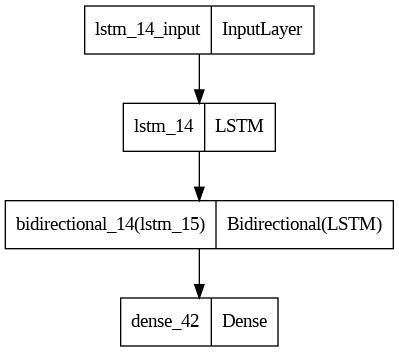

In [882]:
from tensorflow.keras.utils import plot_model
plot_model(lstm_model)

GCN model

In [883]:
ns = 21

# inp_lap = Input((ns, ns))
# inp_feat = Input((ns, sf))

inp_lap = Input((ns, ns))
inp_feat = Input((ns, sf))

x = GraphConv(32, activation='relu')([inp_feat, inp_lap])
x = GraphConv(16, activation='relu')([x, inp_lap])
x = Flatten()(x)


out = Dense(72)(x)

gcn_model = Model([inp_lap, inp_feat], out)

In [884]:
gcn_model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 21, 7)]              0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 21, 21)]             0         []                            
                                                                                                  
 graph_conv_14 (GraphConv)   (None, 21, 32)               256       ['input_16[0][0]',            
                                                                     'input_15[0][0]']            
                                                                                                  
 graph_conv_15 (GraphConv)   (None, 21, 16)               528       ['graph_conv_14[0][0]',

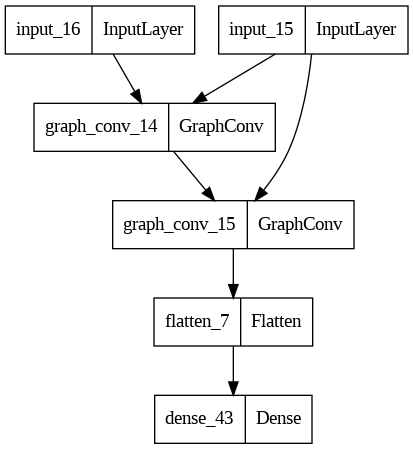

In [885]:
plot_model(gcn_model)

Text model

In [886]:
max_length = 54
input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
lstm_out = tf.keras.layers.Bidirectional(LSTM(max_length, name='LSTM'))(sequence_output) # Bidirectional LSTM instead of LSTM

out = tf.keras.layers.Normalization()(lstm_out)
out = tf.keras.layers.Dense(80, activation="relu")(out)
out = tf.keras.layers.Normalization()(out)
out = tf.keras.layers.Dense(36, activation="relu")(out)

#bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

In [887]:
# Keep the Bert layers trainable
for layer in bert_model.layers:
    layer.trainable = True

In [888]:
bert_model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 54)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 54)]                 0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 54)]                 0         []                            
                                                                                                  
 keras_layer_7 (KerasLayer)  [(None, 768),                1094822   ['input_word_ids[0][0]'

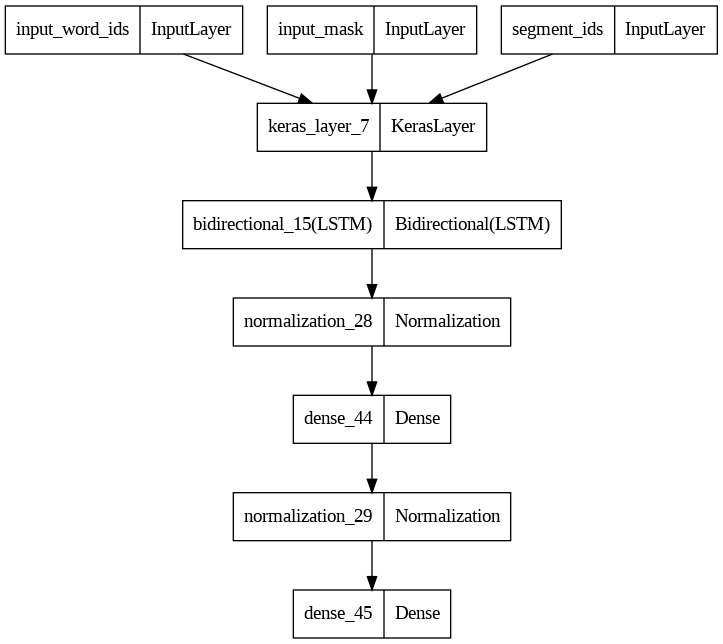

In [889]:
plot_model(bert_model)

In [890]:
# gcn_cor_input.shape

multimodal

In [891]:
from tensorflow.keras import models
# Stacking early-fusion multimodal model
#nClasses = 2 # for multi-class

input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="segment_ids")
lstm_input = tf.keras.layers.Input(shape=(None, Multi_data.shape[1]-4), dtype=tf.float32, name="Price")

gcn_cor_input = tf.keras.layers.Input(shape=(inp_lap.shape[1],inp_lap.shape[2]), dtype=tf.float32, name="cor")
gcn_sf_input = tf.keras.layers.Input(shape=(inp_feat.shape[1],inp_feat.shape[2]), dtype=tf.float32, name="stat_feat")


lstm_side = lstm_model(lstm_input)

gcn_side = gcn_model([gcn_cor_input, gcn_sf_input])

text_side = bert_model([input_word_ids, input_mask, segment_ids])
# Concatenate features from images and texts
merged = tf.keras.layers.Concatenate()([lstm_side, gcn_side, text_side])
merged = tf.keras.layers.Normalization()(merged)
merged = tf.keras.layers.Dense(40, activation="relu")(merged)
merged = tf.keras.layers.Normalization()(merged)
merged = tf.keras.layers.Dense(60, activation="relu")(merged)
output = tf.keras.layers.Dense(1, activation="sigmoid", name="class")(merged)

merge_model = models.Model([lstm_input, gcn_cor_input, gcn_sf_input, input_word_ids, input_mask, segment_ids], output)

In [892]:
merge_model.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Price (InputLayer)          [(None, None, 17)]           0         []                            
                                                                                                  
 cor (InputLayer)            [(None, 21, 21)]             0         []                            
                                                                                                  
 stat_feat (InputLayer)      [(None, 21, 7)]              0         []                            
                                                                                                  
 input_word_ids (InputLayer  [(None, 54)]                 0         []                            
 )                                                                                         

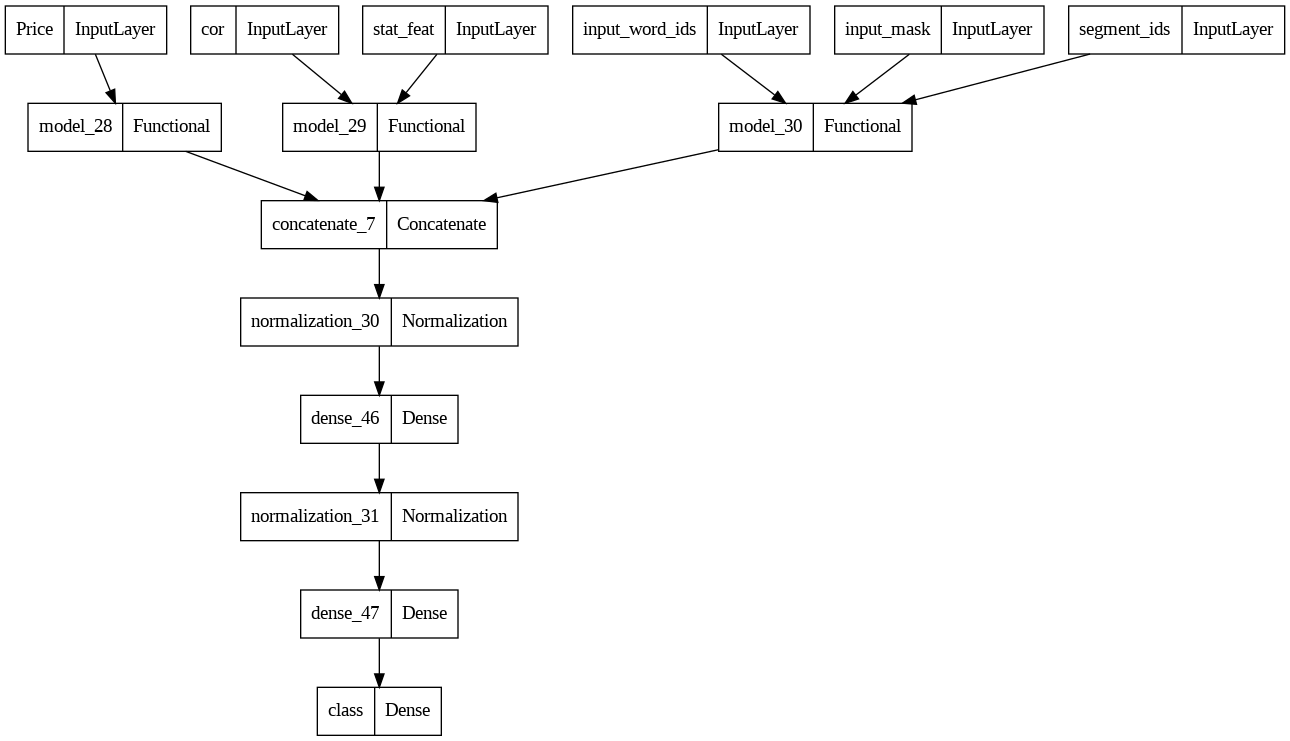

In [893]:
plot_model(merge_model)

# Model Compile

In [894]:
#import mlflow.tensorflow
from tensorflow.keras.optimizers import Adam

In [895]:
# optimizer and metric
merge_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"]) # default lr = 0.001
# n_epochs = 10

In [896]:
# train_data.element_spec

# Early stopping and model saving

In [897]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1) # patience try 5 or 10

# Save and Load model
checkpoint_filepath = '/content/drive/MyDrive/aapl_stock_early_fusion_tuning.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Exponential Scheduling

In [898]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 12.5)

In [899]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=12.5)

In [900]:
import keras

# callbacks=[lr_scheduler]
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Training model

# 10 days in training set 1 day for testing, grad search for hyper parameter tuning, evaluate in next year.

# Function for loop

In [901]:
# convert_data_to_examples: accept train and test datasets and convert each row into an InputExample object.
def convert_train_to_examples(train, DATA_COLUMN, LABEL_COLUMN):
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  return train_InputExamples

In [902]:
# convert_data_to_examples: accept train and test datasets and convert each row into an InputExample object.
def convert_val_to_examples(val, DATA_COLUMN, LABEL_COLUMN):
  val_InputExamples = val.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  return val_InputExamples

In [903]:
# convert_data_to_examples: accept train and test datasets and convert each row into an InputExample object.
def convert_test_to_examples(test, DATA_COLUMN, LABEL_COLUMN):

  test_InputExamples = test.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  return test_InputExamples

In [904]:
DATA_COLUMN = 'Titles'
LABEL_COLUMN = 'Diff'

In [905]:
len(Multi_data)

8484

In [906]:
def dc(d):
  d = d.to_string().split(' ')[-1]
  a = int(d.split('-')[0])
  b = int(d.split('-')[1])
  c = int(d.split('-')[2])
  return date(a,b,c)

In [907]:
# Create a dataset from the generator function
def train_matrix_to_tfdata(data):
  # Define generator function
  def generator(data):
      for i in range(data.shape[0]):
          yield data[i]

  traindata = tf.data.Dataset.from_generator(lambda: generator(data), output_signature=tf.TensorSpec(shape=(ns, ns), dtype=tf.float32))

  # Batch and reshape the dataset
  traindata = traindata.batch(batch_size)
  traindata = traindata.map(lambda x: tf.reshape(x, (batch_size, ns, ns)))

  return traindata

# Create a dataset from the generator function
def test_matrix_to_tfdata(data):
  # Define generator function
  def generator(data):
      for i in range(data.shape[0]):
          yield data[i]

  testdata = tf.data.Dataset.from_generator(lambda: generator(data), output_signature=tf.TensorSpec(shape=(ns, ns), dtype=tf.float32))

  # Batch and reshape the dataset
  testdata = testdata.batch(batch_size)
  testdata = testdata.map(lambda x: tf.reshape(x, (batch_size, ns, ns)))

  return testdata

# Create a dataset from the generator function
def train_matrix_to_tfdatafeat(data):
  # Define generator function
  def generator(data):
      for i in range(data.shape[0]):
          yield data[i]

  trainfeatdata = tf.data.Dataset.from_generator(lambda: generator(data), output_signature=tf.TensorSpec(shape=(ns, sf), dtype=tf.float32))

  # Batch and reshape the dataset
  trainfeatdata = trainfeatdata.batch(batch_size)
  trainfeatdata = trainfeatdata.map(lambda x: tf.reshape(x, (batch_size, ns, sf))) # time_steps

  return trainfeatdata

# Create a dataset from the generator function
def test_matrix_to_tfdatafeat(data):
  # Define generator function
  def generator(data):
      for i in range(data.shape[0]):
          yield data[i]

  testfeatdata = tf.data.Dataset.from_generator(lambda: generator(data), output_signature=tf.TensorSpec(shape=(ns, sf), dtype=tf.float32))

  # Batch and reshape the dataset
  testfeatdata = testfeatdata.batch(batch_size)
  testfeatdata = testfeatdata.map(lambda x: tf.reshape(x, (batch_size, ns, sf)))

  return testfeatdata

In [908]:
def create_features(df, today):

    td = unstaked_df.iloc[:, 0:unstaked_df.columns.get_loc(today)+1]

    all_sequence = td.values

    group_store = all_sequence.reshape((1, ns, -1))

    store_corr = np.stack([np.corrcoef(i) for i in group_store], axis=0)

    store_features = np.stack([
              group_store.mean(axis=2),
              group_store[:,:,1:].mean(axis=2),
              group_store.std(axis=2),
              group_store[:,:,1:].std(axis=2),
              skew(group_store, axis=2),
              kurtosis(group_store, axis=2),
              np.apply_along_axis(lambda x: np.polyfit(np.arange(0, group_store.shape[-1]), x, 1)[0], 2, group_store)
            ], axis=1)

    group_store = np.transpose(group_store, (0,2,1))

    store_features = np.transpose(store_features, (0,2,1))

    return store_corr, store_features

# First model

In [909]:
training = Multi_data.iloc[0:11]
testing = Multi_data[11:13]
testing

,date,Titles,symbol,low,close,high,volume,open,adjclose,rsi,...,26-Day EMA,MACD,SAR,Upper Band,Middle Band,Lower Band,Slow k,Slow d,NextDayClose,Diff
273,2021-01-26,college dropout becomes billionaire chinese ga...,ADBE,0.559193,0.563694,0.559783,0.008469,0.562717,0.564926,0.472812,...,0.555898,0.640786,0.531208,0.559511,0.566048,0.570037,0.862246,0.849495,0.543370,1
294,2021-01-27,influencers andy serwer mubarak muyika,ADBE,0.543184,0.543370,0.555386,0.012957,0.559284,0.544659,0.362575,...,0.554111,0.620200,0.531799,0.565743,0.563588,0.558586,0.656073,0.802950,0.550448,0


In [910]:
# Accumulative price from the beggining of the day and evaluate to traning set
li = []
train = training
feature_traindata = train.iloc[:,3:20].to_numpy()
label_train = train.Diff.values

test = testing
feature_testdata = test.iloc[:,3:20].to_numpy()
label_test = test.Diff.values

time_steps = 10
batch_size = 1

train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
      data = feature_traindata,
      targets = label_train,
      length = time_steps,
      sampling_rate=1,
      stride=1,
      start_index=0,
      end_index=None,
      shuffle=False,
      reverse=False,
      batch_size=batch_size
  )
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
      data = feature_testdata,
      targets = label_test,
      length = 1,
      sampling_rate=1,
      stride=1,
      start_index=0,
      end_index=None,
      shuffle=False,
      reverse=False,
      batch_size=batch_size
  )


###############################################################################################################
### CREATE TRAIN FEATURES ###
# For LSTM

train_head = train.head(1)['date'].to_string().split()[-1]
train_tail = train.tail(1)['date'].to_string().split()[-1]
test_head = test.head(1)['date'].to_string().split()[-1]
test_tail = test.tail(1)['date'].to_string().split()[-1]

X_seq, X_cor, X_feat = [], [], []

for d in unstaked_df.iloc[:, unstaked_df.columns.get_loc(train_head):unstaked_df.columns.get_loc(train_tail)]:
    corr_, feat_ = create_features(unstaked_df, d)
    X_cor.append(corr_), X_feat.append(feat_)

X_train_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_train_feat = np.concatenate(X_feat, axis=0).astype('float16')

print(X_train_cor.shape, X_train_feat.shape)

# ## CREATE TEST FEATURES ###

X_seq, X_cor, X_feat = [], [], []

for d in unstaked_df.iloc[:, unstaked_df.columns.get_loc(test_head):unstaked_df.columns.get_loc(test_tail)+1]:
    corr_, feat_ = create_features(unstaked_df, d)
    X_cor.append(corr_), X_feat.append(feat_)

X_test_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_test_feat = np.concatenate(X_feat, axis=0).astype('float16')

print(X_test_cor.shape, X_test_feat.shape)

### SCALE SEQUENCES ###

scaler_seq = StandardScaler()
scaler_feat = StandardScaler()

X_train_feat = scaler_feat.fit_transform(X_train_feat.reshape(-1,ns)).reshape(X_train_feat.shape)
X_test_feat = scaler_feat.transform(X_test_feat.reshape(-1,ns)).reshape(X_test_feat.shape)

### OBTAIN LAPLACIANS FROM CORRELATIONS ###

X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

stock_cor_train_data = train_matrix_to_tfdata(X_train_lap)
stock_cor_test_data = test_matrix_to_tfdata(X_test_lap)

stock_feat_train_data = train_matrix_to_tfdatafeat(X_train_feat)
stock_feat_test_data = test_matrix_to_tfdatafeat(X_test_feat)
#################################################################################################################

stock_lstm_train_data = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([batch_size, time_steps, feature_traindata.shape[1]], [batch_size,]) # based on batch_size change
  )

stock_lstm_test_data = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([batch_size, 1, feature_testdata.shape[1]], [batch_size,]) # based on batch_size change
  )

  # call above function
train_InputExamples = convert_train_to_examples(train, DATA_COLUMN, LABEL_COLUMN)
  # call above function
test_InputExamples = convert_test_to_examples(test, DATA_COLUMN, LABEL_COLUMN)

stock_train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
stock_train_data = stock_train_data.batch(batch_size, drop_remainder=True)

stock_test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
stock_test_data = stock_test_data.batch(batch_size, drop_remainder=True)

  # price test batch drop remainder
stock_lstm_test_data = stock_lstm_test_data.unbatch()
stock_lstm_test_data = stock_lstm_test_data.batch(batch_size, drop_remainder=True)


  # merged train data
try_data = tf.data.Dataset.zip((stock_lstm_train_data, stock_feat_train_data, stock_cor_train_data, stock_train_data))
try_data.element_spec
train_data = try_data.map(lambda x, x1, x2, y: ((x[0], tf.expand_dims(x2[0], axis=0), tf.expand_dims(x1[0], axis=0), y[0], y[1], y[2]), x[1]))
print(train_data.element_spec)

  # merged validation data
try_data2 = tf.data.Dataset.zip((stock_lstm_test_data, stock_feat_test_data, stock_cor_test_data, stock_test_data))
try_data2.element_spec
test_data = try_data2.map(lambda x, x1, x2, y: ((x[0], tf.expand_dims(x2[0], axis=0), tf.expand_dims(x1[0], axis=0), y[0], y[1], y[2]), x[1]))
print(test_data.element_spec)

  # Train the model
earlyfs_history = merge_model.fit(train_data,
                                    epochs=2, # 20
                                    callbacks=[lr_scheduler],
                                    # verbose=1
  )

eval_results = merge_model.predict(test_data)
print(eval_results)
li.append(eval_results)

(10, 21, 21) (10, 21, 7)
(2, 21, 21) (2, 21, 7)
((TensorSpec(shape=(1, 10, 17), dtype=tf.float32, name=None), TensorSpec(shape=(1, 21, 21), dtype=tf.float32, name=None), TensorSpec(shape=(1, 21, 7), dtype=tf.float32, name=None), TensorSpec(shape=(1, 54), dtype=tf.int32, name=None), TensorSpec(shape=(1, 54), dtype=tf.int32, name=None), TensorSpec(shape=(1, 54), dtype=tf.int32, name=None)), TensorSpec(shape=(1,), dtype=tf.float32, name=None))
((TensorSpec(shape=(1, 1, 17), dtype=tf.float32, name=None), TensorSpec(shape=(1, 21, 21), dtype=tf.float32, name=None), TensorSpec(shape=(1, 21, 7), dtype=tf.float32, name=None), TensorSpec(shape=(1, 54), dtype=tf.int32, name=None), TensorSpec(shape=(1, 54), dtype=tf.int32, name=None), TensorSpec(shape=(1, 54), dtype=tf.int32, name=None)), TensorSpec(shape=(1,), dtype=tf.float32, name=None))
Epoch 1/2
1/1 [==============================] - 63s 63s/step - loss: 0.7896 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/2
1/1 [==============================]

In [911]:
train_data.element_spec

((TensorSpec(shape=(1, 10, 17), dtype=tf.float32, name=None),
  TensorSpec(shape=(1, 21, 21), dtype=tf.float32, name=None),
  TensorSpec(shape=(1, 21, 7), dtype=tf.float32, name=None),
  TensorSpec(shape=(1, 54), dtype=tf.int32, name=None),
  TensorSpec(shape=(1, 54), dtype=tf.int32, name=None),
  TensorSpec(shape=(1, 54), dtype=tf.int32, name=None)),
 TensorSpec(shape=(1,), dtype=tf.float32, name=None))

In [912]:
test_data.element_spec

((TensorSpec(shape=(1, 1, 17), dtype=tf.float32, name=None),
  TensorSpec(shape=(1, 21, 21), dtype=tf.float32, name=None),
  TensorSpec(shape=(1, 21, 7), dtype=tf.float32, name=None),
  TensorSpec(shape=(1, 54), dtype=tf.int32, name=None),
  TensorSpec(shape=(1, 54), dtype=tf.int32, name=None),
  TensorSpec(shape=(1, 54), dtype=tf.int32, name=None)),
 TensorSpec(shape=(1,), dtype=tf.float32, name=None))

# Tuning data

In [913]:
# # train = Multi_data[0:11]
# # feature_traindata = train.iloc[:,3:20].to_numpy()
# # label_train = train.Diff.values

# # test = Multi_data[9:10+1]
# # feature_testdata = test.iloc[:,3:20].to_numpy()
# # label_test = test.Diff.values

# # time_steps = 10
# # batch_size = 1

# train = Multi_data[0:21]
# feature_traindata = train.iloc[:,3:20].to_numpy()
# label_train = train.Diff.values

# test = Multi_data[19:20+1]
# feature_testdata = test.iloc[:,3:20].to_numpy()
# label_test = test.Diff.values

# time_steps = 20
# batch_size = 1

# train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
#       data = feature_traindata,
#       targets = label_train,
#       length = time_steps,
#       sampling_rate=1,
#       stride=1,
#       start_index=0,
#       end_index=None,
#       shuffle=False,
#       reverse=False,
#       batch_size=batch_size
#   )
# test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
#       data = feature_testdata,
#       targets = label_test,
#       length = 1,
#       sampling_rate=1,
#       stride=1,
#       start_index=0,
#       end_index=None,
#       shuffle=False,
#       reverse=False,
#       batch_size=batch_size
#   )
# #################################################################################################################
# train_head = train.head(1)['date'].to_string().split()[-1]
# train_tail = train.tail(1)['date'].to_string().split()[-1]
# test_head = test.head(1)['date'].to_string().split()[-1]
# test_tail = test.tail(1)['date'].to_string().split()[-1]

# X_seq, X_cor, X_feat = [], [], []

# for d in unstaked_df.iloc[:, unstaked_df.columns.get_loc(train_head):unstaked_df.columns.get_loc(train_tail)]:
#     corr_, feat_ = create_features(unstaked_df, d)
#     X_cor.append(corr_), X_feat.append(feat_)

# X_train_cor = np.concatenate(X_cor, axis=0).astype('float16')
# X_train_feat = np.concatenate(X_feat, axis=0).astype('float16')

# print(X_train_cor.shape, X_train_feat.shape)

# # ## CREATE TEST FEATURES ###

# X_seq, X_cor, X_feat = [], [], []

# for d in unstaked_df.iloc[:, unstaked_df.columns.get_loc(test_head):unstaked_df.columns.get_loc(test_tail)+1]:
#     corr_, feat_ = create_features(unstaked_df, d)
#     X_cor.append(corr_), X_feat.append(feat_)

# X_test_cor = np.concatenate(X_cor, axis=0).astype('float16')
# X_test_feat = np.concatenate(X_feat, axis=0).astype('float16')

# print(X_test_cor.shape, X_test_feat.shape)

# ### SCALE SEQUENCES ###

# scaler_seq = StandardScaler()
# scaler_feat = StandardScaler()

# X_train_feat = scaler_feat.fit_transform(X_train_feat.reshape(-1,ns)).reshape(X_train_feat.shape)
# X_test_feat = scaler_feat.transform(X_test_feat.reshape(-1,ns)).reshape(X_test_feat.shape)

# ### OBTAIN LAPLACIANS FROM CORRELATIONS ###

# X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
# X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

# stock_cor_train_data = train_matrix_to_tfdata(X_train_lap)
# stock_cor_test_data = test_matrix_to_tfdata(X_test_lap)

# stock_feat_train_data = train_matrix_to_tfdatafeat(X_train_feat)
# stock_feat_test_data = test_matrix_to_tfdatafeat(X_test_feat)
# #################################################################################################################

# stock_lstm_train_data = tf.data.Dataset.from_generator(
#     lambda: train_generator,
#     output_types=(tf.float32, tf.float32),
#     output_shapes=([batch_size, time_steps, feature_traindata.shape[1]], [batch_size,]) # based on batch_size change
#   )

# stock_lstm_test_data = tf.data.Dataset.from_generator(
#     lambda: test_generator,
#     output_types=(tf.float32, tf.float32),
#     output_shapes=([batch_size, 1, feature_testdata.shape[1]], [batch_size,]) # based on batch_size change
#   )

#   # call above function
# train_InputExamples = convert_train_to_examples(train, DATA_COLUMN, LABEL_COLUMN)
#   # call above function
# test_InputExamples = convert_test_to_examples(test, DATA_COLUMN, LABEL_COLUMN)

# stock_train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
# stock_train_data = stock_train_data.batch(batch_size, drop_remainder=True)

# stock_test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
# stock_test_data = stock_test_data.batch(batch_size, drop_remainder=True)

#   # price test batch drop remainder
# stock_lstm_test_data = stock_lstm_test_data.unbatch()
# stock_lstm_test_data = stock_lstm_test_data.batch(batch_size, drop_remainder=True)


#   # merged train data
# try_data = tf.data.Dataset.zip((stock_lstm_train_data, stock_feat_train_data, stock_cor_train_data, stock_train_data))
# try_data.element_spec
# train_data = try_data.map(lambda x, x1, x2, y: ((x[0], tf.expand_dims(x2[0], axis=0), tf.expand_dims(x1[0], axis=0), y[0], y[1], y[2]), x[1]))
# print(train_data.element_spec)

#   # merged validation data
# try_data2 = tf.data.Dataset.zip((stock_lstm_test_data, stock_feat_test_data, stock_cor_test_data, stock_test_data))
# try_data2.element_spec
# test_data = try_data2.map(lambda x, x1, x2, y: ((x[0], tf.expand_dims(x2[0], axis=0), tf.expand_dims(x1[0], axis=0), y[0], y[1], y[2]), x[1]))
# print(test_data.element_spec)

# Tuning test

In [914]:
# !pip install keras-tuner --upgrade

In [915]:
# import keras_tuner
# from tensorflow import keras
# from keras import backend as K
# from tensorflow.keras import layers, losses
# import numpy as np
# import matplotlib.pyplot as plt
# import os

In [916]:
# class MyHyperModel(keras_tuner.HyperModel) :
#     def build(self, hp, classes=1) :
#         # define model
#         input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
#         input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_mask")
#         segment_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="segment_ids")
#         lstm_input = tf.keras.layers.Input(shape=(None, Multi_data.shape[1]-4), dtype=tf.float32, name="Price")

#         gcn_cor_input = tf.keras.layers.Input(shape=(inp_lap.shape[1],inp_lap.shape[2]), dtype=tf.float32, name="cor")
#         gcn_sf_input = tf.keras.layers.Input(shape=(inp_feat.shape[1],inp_feat.shape[2]), dtype=tf.float32, name="stat_feat")


#         lstm_side = lstm_model(lstm_input)

#         gcn_side = gcn_model([gcn_cor_input, gcn_sf_input])

#         text_side = bert_model([input_word_ids, input_mask, segment_ids])
#         # Concatenate features from images and texts
#         merged = tf.keras.layers.Concatenate()([lstm_side, gcn_side, text_side])

#         # Number of Layers is up to tuning
#         for i in range(hp.Int("num_layer", min_value=2, max_value=8, step=2)) :
#             # Tune hyperparams of each conv layer separately by using f"...{i}"

#             merged = (layers.Normalization())(merged)

#             merged = (layers.Dense(hp.Int(name=f"Dense_{i}", min_value=40, max_value=160, step=20),
#                                     activation=hp.Choice('layer_opt',['relu'])))(merged)


#         # Last layer
#         output = (layers.Dense(classes, activation='sigmoid'))(merged)

#         model = models.Model([lstm_input, gcn_cor_input, gcn_sf_input, input_word_ids, input_mask, segment_ids], output)

#         # Picking an opimizer and a loss function
#         model.compile(optimizer=hp.Choice('optim',['adam']),
#                       loss="binary_crossentropy",
#                       metrics = ['accuracy'])

#         # A way to optimize the learning rate while also trying different optimizers
#         learning_rate = hp.Choice('lr', [0.0001])
#         K.set_value(model.optimizer.learning_rate, learning_rate)

#         return model


#     def fit(self, hp, model,x, *args, **kwargs) :

#         return model.fit( x,
#                          *args,
#                          shuffle=hp.Boolean("shuffle"),
#                          **kwargs)

In [917]:
# classes = 1
# BATCH_SIZE = 1
# hp = keras_tuner.HyperParameters()
# hypermodel = MyHyperModel()
# model = hypermodel.build(hp, classes)

In [918]:
# tuner = keras_tuner.BayesianOptimization(
#                         hypermodel=MyHyperModel(),
#                         objective = "val_accuracy",
#                         max_trials = tmax_trials, #max candidates to test
#                         overwrite=True,
#                         directory='BO_search_dir',
#                         project_name='multimodal_lstm_bert')

In [919]:
# model.summary()

In [920]:
# tuner.search(x=train_data,
#              validation_data = test_data,
#              epochs=tepochs,
#              callbacks=[earlystopping])

In [921]:
# tuner.results_summary(1)

In [922]:
# tuner.get_best_hyperparameters(5)

In [923]:
# # Get the top 2 hyperparameters.
# best_hps = tuner.get_best_hyperparameters(1)
# # Build the model with the best hp.
# h_model = MyHyperModel()
# merge_model = h_model.build(best_hps[0])

In [924]:
merge_model.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Price (InputLayer)          [(None, None, 17)]           0         []                            
                                                                                                  
 cor (InputLayer)            [(None, 21, 21)]             0         []                            
                                                                                                  
 stat_feat (InputLayer)      [(None, 21, 7)]              0         []                            
                                                                                                  
 input_word_ids (InputLayer  [(None, 54)]                 0         []                            
 )                                                                                         

In [925]:
# history = model.fit(x=train_data,
#                     validation_data=test_data,
#                     epochs=100,
#                     callbacks=[earlystopping])


# For Uptrend or Downtrend

In [926]:
Multi_data['symbol'] = Multi_data['symbol'].apply(str.upper)
Multi_data = Multi_data[Multi_data['symbol'] == triker1]
# rslt_df = dataframe[dataframe['Stream'].isin(options)]

In [927]:
def startday(trend):
  if trend == 'downtrend':
    data = Multi_data[Multi_data['date']>= '2022-01-01']
  elif trend == 'uptrend':
    data = Multi_data[Multi_data['date']>= '2021-07-01']
    data = data[data['date']< '2022-01-01']
  return data

data_2022 = startday(trend)
data_2022

,date,Titles,symbol,low,close,high,volume,open,adjclose,rsi,...,26-Day EMA,MACD,SAR,Upper Band,Middle Band,Lower Band,Slow k,Slow d,NextDayClose,Diff
4806,2022-01-03,apple becomes first company worth $ 3 trillion,AAPL,0.193273,0.196325,0.195279,0.383091,0.191966,0.197660,0.675492,...,0.669672,0.634382,0.179735,0.194399,0.195032,0.194937,0.480317,0.557494,0.193441,1
4827,2022-01-04,apple aapl rumored develop cheaper mac exter...,AAPL,0.195052,0.193441,0.195354,0.364099,0.197980,0.194796,0.620242,...,0.668894,0.631438,0.180708,0.194522,0.195136,0.195020,0.462159,0.475835,0.187473,0
4848,2022-01-05,7 stocks buy benefit biden big antitrust plans,AAPL,0.189400,0.187473,0.191923,0.346591,0.194196,0.188870,0.521354,...,0.666893,0.617815,0.181934,0.195443,0.194008,0.191777,0.433993,0.466664,0.183828,0
4869,2022-01-06,acorns moves onto robinhood turf direct stock...,AAPL,0.185616,0.183828,0.185892,0.355271,0.185538,0.185250,0.469750,...,0.663509,0.602413,0.196031,0.196801,0.192440,0.187188,0.160092,0.357586,0.184040,0
4890,2022-01-07,focus-at ces tech alliances firm self-driving...,AAPL,0.184846,0.184040,0.184456,0.317874,0.185776,0.185461,0.472813,...,0.659341,0.593683,0.195751,0.196760,0.191075,0.184458,0.047661,0.216395,0.184065,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8481,2022-09-14,apple plans use latest chip tech taiwan tsmc ...,AAPL,0.162869,0.162992,0.163354,0.322482,0.163098,0.165355,0.402826,...,0.598908,0.604609,0.159156,0.171505,0.166705,0.161137,0.416181,0.526183,0.159322,1
8502,2022-09-15,alphabet googl enhances google photos recent...,AAPL,0.160056,0.159322,0.161051,0.331710,0.162922,0.161695,0.363627,...,0.595479,0.601916,0.172917,0.171907,0.166177,0.159648,0.129441,0.369415,0.157237,0
8523,2022-09-16,apple counts upscale shoppers turn latest ipho...,AAPL,0.156259,0.157237,0.156233,0.594637,0.158612,0.159616,0.342482,...,0.591770,0.598799,0.172599,0.171661,0.164490,0.156479,0.145087,0.233073,0.161956,0
8544,2022-09-19,eps growth apple nasdaq aapl makes interes...,AAPL,0.157180,0.161956,0.160209,0.298671,0.156232,0.164322,0.414033,...,0.588872,0.607831,0.171825,0.162531,0.162227,0.161342,0.237675,0.172269,0.164977,1


In [928]:
def mulday(trend):
  if trend == 'downtrend':
    Full_data = Multi_data
  elif trend == 'uptrend':
    Full_data = Multi_data[Multi_data['date']< '2022-01-01']
  return Full_data

In [929]:
Full_data = mulday(trend)
Full_data

,date,Titles,symbol,low,close,high,volume,open,adjclose,rsi,...,26-Day EMA,MACD,SAR,Upper Band,Middle Band,Lower Band,Slow k,Slow d,NextDayClose,Diff
18,2021-01-05,two former apple insiders building laser techn...,AAPL,0.131103,0.132656,0.131949,0.358063,0.130646,0.133437,0.570810,...,0.649446,0.634986,0.141105,0.137270,0.135680,0.133609,0.256122,0.302928,0.127150,1
60,2021-01-07,dow jones futures rise congress certifies bid...,AAPL,0.130384,0.132544,0.131813,0.401764,0.129982,0.133326,0.550443,...,0.645898,0.620524,0.140222,0.134794,0.132882,0.130491,0.302902,0.254369,0.133954,1
81,2021-01-08,best mutual funds bet tech stocks ipos keep r...,AAPL,0.133374,0.133954,0.133051,0.385550,0.135082,0.134719,0.570062,...,0.644391,0.623313,0.139655,0.134264,0.132720,0.130711,0.448030,0.319739,0.130122,1
102,2021-01-11,short selling legend jim chanos top 10 stock ...,AAPL,0.131191,0.130122,0.130005,0.368039,0.131022,0.130936,0.502431,...,0.642420,0.618146,0.139111,0.134242,0.132611,0.130513,0.580413,0.451294,0.129897,0
123,2021-01-12,world top maker mini motors bets win tesla,AAPL,0.129122,0.129897,0.129410,0.337103,0.130157,0.130714,0.498611,...,0.640145,0.614760,0.138588,0.133572,0.132052,0.130073,0.527925,0.527944,0.132506,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8481,2022-09-14,apple plans use latest chip tech taiwan tsmc ...,AAPL,0.162869,0.162992,0.163354,0.322482,0.163098,0.165355,0.402826,...,0.598908,0.604609,0.159156,0.171505,0.166705,0.161137,0.416181,0.526183,0.159322,1
8502,2022-09-15,alphabet googl enhances google photos recent...,AAPL,0.160056,0.159322,0.161051,0.331710,0.162922,0.161695,0.363627,...,0.595479,0.601916,0.172917,0.171907,0.166177,0.159648,0.129441,0.369415,0.157237,0
8523,2022-09-16,apple counts upscale shoppers turn latest ipho...,AAPL,0.156259,0.157237,0.156233,0.594637,0.158612,0.159616,0.342482,...,0.591770,0.598799,0.172599,0.171661,0.164490,0.156479,0.145087,0.233073,0.161956,0
8544,2022-09-19,eps growth apple nasdaq aapl makes interes...,AAPL,0.157180,0.161956,0.160209,0.298671,0.156232,0.164322,0.414033,...,0.588872,0.607831,0.171825,0.162531,0.162227,0.161342,0.237675,0.172269,0.164977,1


In [930]:
data_tail205 = Full_data.tail(len(data_2022)+22)
data_tail205

,date,Titles,symbol,low,close,high,volume,open,adjclose,rsi,...,26-Day EMA,MACD,SAR,Upper Band,Middle Band,Lower Band,Slow k,Slow d,NextDayClose,Diff
4344,2021-11-30,1 fast-growing stock reshaping industry,AAPL,0.170830,0.175464,0.173781,0.638257,0.169613,0.176944,0.730894,...,0.642774,0.670530,0.160185,0.174940,0.172088,0.168509,0.478134,0.457320,0.174802,1
4365,2021-12-01,7 penny stocks 10x potential 2022,AAPL,0.176646,0.174802,0.179701,0.557571,0.178998,0.176287,0.713940,...,0.645578,0.671303,0.161346,0.176690,0.172937,0.168420,0.665077,0.518736,0.173541,0
4386,2021-12-02,apple partner foxconn talks help saudi arabia ...,AAPL,0.168155,0.173541,0.172146,0.501398,0.168047,0.175034,0.681208,...,0.647987,0.666923,0.163251,0.177386,0.173397,0.168634,0.703949,0.626997,0.171144,0
4407,2021-12-03,amazon amzn 18 projects bolster net-zero ca...,AAPL,0.170578,0.171144,0.173088,0.432742,0.174663,0.172654,0.621721,...,0.649546,0.657450,0.164924,0.175352,0.174669,0.173324,0.484116,0.629034,0.175489,0
4428,2021-12-06,goldman morgan stanley bid buy india mapmaker...,AAPL,0.176330,0.175489,0.176704,0.394129,0.175001,0.176968,0.679013,...,0.651091,0.657289,0.164924,0.175176,0.175953,0.176113,0.483544,0.567199,0.182804,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8481,2022-09-14,apple plans use latest chip tech taiwan tsmc ...,AAPL,0.162869,0.162992,0.163354,0.322482,0.163098,0.165355,0.402826,...,0.598908,0.604609,0.159156,0.171505,0.166705,0.161137,0.416181,0.526183,0.159322,1
8502,2022-09-15,alphabet googl enhances google photos recent...,AAPL,0.160056,0.159322,0.161051,0.331710,0.162922,0.161695,0.363627,...,0.595479,0.601916,0.172917,0.171907,0.166177,0.159648,0.129441,0.369415,0.157237,0
8523,2022-09-16,apple counts upscale shoppers turn latest ipho...,AAPL,0.156259,0.157237,0.156233,0.594637,0.158612,0.159616,0.342482,...,0.591770,0.598799,0.172599,0.171661,0.164490,0.156479,0.145087,0.233073,0.161956,0
8544,2022-09-19,eps growth apple nasdaq aapl makes interes...,AAPL,0.157180,0.161956,0.160209,0.298671,0.156232,0.164322,0.414033,...,0.588872,0.607831,0.171825,0.162531,0.162227,0.161342,0.237675,0.172269,0.164977,1


In [ ]:
# Accumulative price from the beggining of the day and evaluate to traning set
li = []
for i in range(0,len(data_tail205)-22):
  train = data_tail205.iloc[0:21+i]
  feature_traindata = train.iloc[:,3:20].to_numpy()
  label_train = train.Diff.values

  val = data_tail205.iloc[0:21+i]
  feature_valdata = val.iloc[:,3:20].to_numpy()
  label_val = val.Diff.values

  test = data_tail205.iloc[21+i:23+i]
  feature_testdata = test.iloc[:,3:20].to_numpy()
  label_test = test.Diff.values

  time_steps = 20+i
  batch_size = 1

  train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
      data = feature_traindata,
      targets = label_train,
      length = time_steps,
      sampling_rate=1,
      stride=1,
      start_index=0,
      end_index=None,
      shuffle=False,
      reverse=False,
      batch_size=batch_size
  )

  val_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
      data = feature_valdata,
      targets = label_val,
      length = time_steps,
      sampling_rate=1,
      stride=1,
      start_index=0,
      end_index=None,
      shuffle=False,
      reverse=False,
      batch_size=batch_size
  )

  test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
      data = feature_testdata,
      targets = label_test,
      length = 1,
      sampling_rate=1,
      stride=1,
      start_index=0,
      end_index=None,
      shuffle=False,
      reverse=False,
      batch_size=batch_size
  )

  ###############################################################################################################
  ### CREATE TRAIN FEATURES ###
  # For LSTM

  # train_date = dc(train.head(1)['date'])

  # test_date = dc(test.head(1)['date'])

  # final_date = dc(test.tail(1)['date'])

  train_head = train.head(1)['date'].to_string().split()[-1]
  train_tail = train.tail(1)['date'].to_string().split()[-1]
  test_head = test.head(1)['date'].to_string().split()[-1]
  test_tail = test.tail(1)['date'].to_string().split()[-1]

  X_seq, X_cor, X_feat = [], [], []

  for d in unstaked_df.iloc[:, unstaked_df.columns.get_loc(train_head):unstaked_df.columns.get_loc(train_tail)]:
      corr_, feat_ = create_features(unstaked_df, d)
      X_cor.append(corr_), X_feat.append(feat_)

  X_train_cor = np.concatenate(X_cor, axis=0).astype('float16')
  X_train_feat = np.concatenate(X_feat, axis=0).astype('float16')

  print(X_train_cor.shape, X_train_feat.shape)
  #val
  valtrain_today = training.head(1)['date'].to_string().split()[-1]
  valtest_today = testing.head(1)['date'].to_string().split()[-1]

  X_seq, X_cor, X_feat = [], [], []

  for d in unstaked_df.iloc[:, unstaked_df.columns.get_loc(train_head):unstaked_df.columns.get_loc(train_tail)]:
      corr_, feat_ = create_features(unstaked_df, d)
      X_cor.append(corr_), X_feat.append(feat_)

  X_val_cor = np.concatenate(X_cor, axis=0).astype('float16')
  X_val_feat = np.concatenate(X_feat, axis=0).astype('float16')

  print(X_val_cor.shape, X_val_feat.shape)

  # ## CREATE TEST FEATURES ###

  X_seq, X_cor, X_feat = [], [], []

  for d in unstaked_df.iloc[:, unstaked_df.columns.get_loc(test_head):unstaked_df.columns.get_loc(test_tail)+1]:
      corr_, feat_ = create_features(unstaked_df, d)
      X_cor.append(corr_), X_feat.append(feat_)

  X_test_cor = np.concatenate(X_cor, axis=0).astype('float16')
  X_test_feat = np.concatenate(X_feat, axis=0).astype('float16')

  print(X_test_cor.shape, X_test_feat.shape)

  ### SCALE SEQUENCES ###

  scaler_seq = StandardScaler()
  scaler_feat = StandardScaler()

  X_train_feat = scaler_feat.fit_transform(X_train_feat.reshape(-1,ns)).reshape(X_train_feat.shape)
  X_val_feat = scaler_feat.fit_transform(X_val_feat.reshape(-1,ns)).reshape(X_val_feat.shape)
  X_test_feat = scaler_feat.transform(X_test_feat.reshape(-1,ns)).reshape(X_test_feat.shape)

  ### OBTAIN LAPLACIANS FROM CORRELATIONS ###

  X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
  X_val_lap = localpooling_filter(1 - np.abs(X_val_cor))
  X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

  stock_cor_train_data = train_matrix_to_tfdata(X_train_lap)
  stock_cor_val_data = train_matrix_to_tfdata(X_val_lap)
  stock_cor_test_data = test_matrix_to_tfdata(X_test_lap)

  stock_feat_train_data = train_matrix_to_tfdatafeat(X_train_feat)
  stock_feat_val_data = train_matrix_to_tfdatafeat(X_val_feat)
  stock_feat_test_data = test_matrix_to_tfdatafeat(X_test_feat)
  #################################################################################################################

  stock_lstm_train_data = tf.data.Dataset.from_generator(
      lambda: train_generator,
      output_types=(tf.float32, tf.float32),
      output_shapes=([batch_size, time_steps, feature_traindata.shape[1]], [batch_size,]) # based on batch_size change
    )

  stock_lstm_val_data = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([batch_size, time_steps, feature_valdata.shape[1]], [batch_size,]) # based on batch_size change
  )

  stock_lstm_test_data = tf.data.Dataset.from_generator(
      lambda: test_generator,
      output_types=(tf.float32, tf.float32),
      output_shapes=([batch_size, 1, feature_testdata.shape[1]], [batch_size,]) # based on batch_size change
    )

    # call above function
  train_InputExamples = convert_train_to_examples(train, DATA_COLUMN, LABEL_COLUMN)
  val_InputExamples = convert_val_to_examples(val, DATA_COLUMN, LABEL_COLUMN)
  test_InputExamples = convert_test_to_examples(test, DATA_COLUMN, LABEL_COLUMN)

  stock_train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
  stock_train_data = stock_train_data.batch(batch_size, drop_remainder=True)

  stock_val_data = convert_examples_to_tf_dataset(list(val_InputExamples), tokenizer)
  stock_val_data = stock_val_data.batch(batch_size, drop_remainder=True)

  stock_test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
  stock_test_data = stock_test_data.batch(batch_size, drop_remainder=True)

    # price test batch drop remainder
  stock_lstm_test_data = stock_lstm_test_data.unbatch()
  stock_lstm_test_data = stock_lstm_test_data.batch(batch_size, drop_remainder=True)


    # merged train data
  try_data = tf.data.Dataset.zip((stock_lstm_train_data, stock_feat_train_data, stock_cor_train_data, stock_train_data))
  try_data.element_spec
  train_data = try_data.map(lambda x, x1, x2, y: ((x[0], tf.expand_dims(x2[0], axis=0), tf.expand_dims(x1[0], axis=0), y[0], y[1], y[2]), x[1]))
  print(train_data.element_spec)

  try_valdata = tf.data.Dataset.zip((stock_lstm_val_data, stock_feat_val_data, stock_cor_val_data, stock_val_data))
  try_valdata.element_spec
  val_data = try_valdata.map(lambda x, x1, x2, y: ((x[0], tf.expand_dims(x2[0], axis=0), tf.expand_dims(x1[0], axis=0), y[0], y[1], y[2]), x[1]))
  print(train_data.element_spec)

    # merged validation data
  try_data2 = tf.data.Dataset.zip((stock_lstm_test_data, stock_feat_test_data, stock_cor_test_data, stock_test_data))
  try_data2.element_spec
  test_data = try_data2.map(lambda x, x1, x2, y: ((x[0], tf.expand_dims(x2[0], axis=0), tf.expand_dims(x1[0], axis=0), y[0], y[1], y[2]), x[1]))
  print(test_data.element_spec)

  # Train the model
  earlyfs_history = merge_model.fit(train_data,
                                    epochs=fepochs,
                                    callbacks=[earlystopping],
                                    validation_data = val_data
                                    # verbose=1
  )

  eval_results = merge_model.predict(test_data)
  print(eval_results)
  li.append(eval_results)
  print(len(data_tail205)-22-i)

(21, 21, 21) (21, 21, 7)
(21, 21, 21) (21, 21, 7)
(2, 21, 21) (2, 21, 7)
((TensorSpec(shape=(1, 20, 17), dtype=tf.float32, name=None), TensorSpec(shape=(1, 21, 21), dtype=tf.float32, name=None), TensorSpec(shape=(1, 21, 7), dtype=tf.float32, name=None), TensorSpec(shape=(1, 54), dtype=tf.int32, name=None), TensorSpec(shape=(1, 54), dtype=tf.int32, name=None), TensorSpec(shape=(1, 54), dtype=tf.int32, name=None)), TensorSpec(shape=(1,), dtype=tf.float32, name=None))
((TensorSpec(shape=(1, 20, 17), dtype=tf.float32, name=None), TensorSpec(shape=(1, 21, 21), dtype=tf.float32, name=None), TensorSpec(shape=(1, 21, 7), dtype=tf.float32, name=None), TensorSpec(shape=(1, 54), dtype=tf.int32, name=None), TensorSpec(shape=(1, 54), dtype=tf.int32, name=None), TensorSpec(shape=(1, 54), dtype=tf.int32, name=None)), TensorSpec(shape=(1,), dtype=tf.float32, name=None))
((TensorSpec(shape=(1, 1, 17), dtype=tf.float32, name=None), TensorSpec(shape=(1, 21, 21), dtype=tf.float32, name=None), TensorSpec(s

In [ ]:
li = np.array(li)
y_pred = np.where(li > 0.5, 1, 0)

In [ ]:
true_y = data_tail205.tail(len(y_pred)).Diff.values
true_y

In [ ]:
y_PRED = []
for i in range(0, len(li)):
  k = y_pred[i][0][0]
  y_PRED.append(k)
y_PRED = np.array(y_PRED)
y_PRED

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_y, y_PRED)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(true_y, y_PRED)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [ ]:
from sklearn.metrics import classification_report
print('Results on the test set:')
cr = classification_report(true_y, y_PRED, output_dict=True)
print(cr)

In [ ]:
acc = str(round(cr['accuracy']*100, 2))
acc

In [ ]:
crdf = pd.DataFrame(cr).transpose()
crdf

In [ ]:
# crdf.to_csv(path + 'classreport_'+triker + '_' + trend +'_' + acc + '.csv', index=False)

In [ ]:
conf_matrix = confusion_matrix(true_y, y_PRED)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
# plt.savefig(path + triker + '_' + trend +'_' + acc + 'confusionmatrix.png')
plt.show()

In [ ]:
obs = np.arange(0,len(y_PRED))
len(obs)

In [ ]:
date_2 = data_2022['date']
len(date_2)

In [ ]:
data = {'': obs,
        'y_PRED': y_PRED,
        'ground_truth': true_y,
        'dates': date_2}

df = pd.DataFrame(data)
df

In [ ]:
print(path + triker + '_' + trend +'_' + acc + '_GCN_Multi.csv')

In [ ]:
# df.to_csv(path + triker1 + '_' + trend +'_' + acc + '_GCN_LSTMulti.csv', index=False)
# df.to_csv('/content/drive/MyDrive/stock_results_tuned/GCN_LSTMulti/' + triker1 + '_' + trend +'_' + acc + '_GCN_LSTMulti.csv', index=False)
df.to_csv(path + triker + '_' + trend +'_' + acc + '_GCN_Multi.csv', index=False)

# Load model

In [ ]:
# model_structure = merge_model.to_json()
# with open(path + triker + '_' + trend +'_' + acc + '.json', 'w') as json_file:
#     json_file.write(model_structure)
# merge_model.save_weights(path + triker + '_' + trend +'_' + acc + '.h5')
# print('Model saved.')

In [ ]:
# from keras.models import model_from_json
# with open(path + triker + '_' + trend +'_' + acc + '.json', 'r') as json_file:
#     json_string = json_file.read()
# model = model_from_json(json_string)

# model.load_weights(path + triker + '_' + trend +'_' + acc + '.h5')